## Setup: Finnhub API Key

This notebook uses real market data from [Finnhub](https://finnhub.io/) (free tier: 60 API calls/min).

**To use real data:**
1. Get a free API key at https://finnhub.io/register
2. Set environment variable: `export FINNHUB_API_KEY=your_key_here`
3. Or enter the key when prompted

**Without a key:** The notebook falls back to synthetic data generation.

# Signature-Based Optimal Stopping for HFT

## Overview

This notebook demonstrates **signature-based optimal stopping** - a principled approach to timing decisions in high-frequency trading using path signatures from rough path theory.

### The Optimal Stopping Problem

Given a stochastic process $X_t$ (e.g., price trajectory, spread evolution), we want to find the stopping time $\tau^*$ that maximizes expected reward:

$$
V(x) = \sup_{\tau \in \mathcal{T}} \mathbb{E}[R(X_\tau) \mid X_0 = x]
$$

where:
- $R(\cdot)$ is the **reward function** (profit from trade execution, avoided costs, etc.)
- $\mathcal{T}$ is the set of admissible stopping times
- $V(x)$ is the **value function** (optimal expected reward)

### Why Path Signatures?

Traditional approaches use **point-in-time features** (current price, volume, etc.). Path signatures capture **entire path history** through iterated integrals:

$$
\text{Sig}_N(X)_{0,t} = \left(1, \int_0^t dX_s, \int_0^t \int_0^s dX_u \otimes dX_s, \ldots \right)
$$

**Key advantages:**
1. **Universal approximation**: Signatures uniquely characterize paths (Chen's theorem)
2. **Reparameterization invariant**: Robust to irregular sampling
3. **Captures dynamics**: Trend, acceleration, volatility interactions automatically encoded

### Trading Applications

- **Triangular arbitrage**: When to execute multi-leg trades
- **Market making**: When to cancel resting orders
- **Pairs trading**: Optimal entry/exit on mean reversion
- **Execution**: When to cross the spread vs. wait in queue

Finnhub helper not available: No module named 'python'
Path length: 3000 steps
Window size: 100 steps
Stopped at t=100 (score=0.9315)
Path value at stop: 0.6807


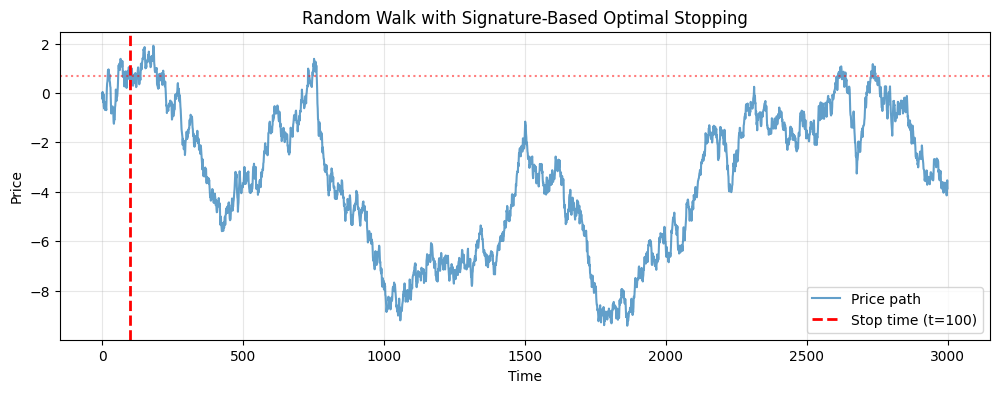

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Import Finnhub helper for real market data
try:
    from python.finnhub_helper import fetch_historical_simulation, get_finnhub_api_key, create_orderbook_from_quote
    FINNHUB_AVAILABLE = True
except Exception as e:
    print(f"Finnhub helper not available: {e}")
    FINNHUB_AVAILABLE = False


# Seed for reproducibility
np.random.seed(123)

# Generate synthetic price path (random walk with drift)
T = 3000  # Total time steps
drift = 0.0001  # Slight upward drift
volatility = 0.2
x = np.cumsum(drift + np.random.randn(T) * volatility)

# Rolling window for signature approximation
win = 100  # Window length

# Compute signature features over rolling windows
m1 = []  # Level 1: Mean (linear term)
m2 = []  # Level 2: Variance (quadratic term)
m3 = []  # Level 3: Skewness (cubic term)

for t in range(win, T):
    w = x[t-win:t] - x[t-win]  # Incremental path (normalized to start at 0)
    m1.append(w.mean())
    m2.append(np.mean(w * w))
    m3.append(np.mean(w * w * w))

# Continuation score: weighted combination of signature features
# These weights would ideally be learned from training data
alpha1, alpha2, alpha3 = 1.0, 0.5, 0.1
sc = np.array(m1) + alpha2 * np.sqrt(np.maximum(m2, 0)) + alpha3 * np.array(m3)

# Stopping rule: stop when score exceeds threshold
threshold = 0.2
stop_candidates = np.where(sc > threshold)[0]
stop = win + stop_candidates[0] if len(stop_candidates) > 0 else T - 1

print(f"Path length: {T} steps")
print(f"Window size: {win} steps")
print(f"Stopped at t={stop} (score={sc[stop-win]:.4f})")
print(f"Path value at stop: {x[stop]:.4f}")

# Visualization
plt.figure(figsize=(12, 4))
plt.plot(x, label='Price path', alpha=0.7)
plt.axvline(stop, ls='--', color='red', label=f'Stop time (t={stop})', linewidth=2)
plt.axhline(x[stop], ls=':', color='red', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Random Walk with Signature-Based Optimal Stopping')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Implementation: Tractable Signature Approximation

We'll use **polynomial moments** as a computationally efficient approximation to full signature features:

- **Level 1** (linear): $\mu_1(w) = \frac{1}{L} \sum_{i=1}^L w_i$ (mean increment)
- **Level 2** (quadratic): $\mu_2(w) = \frac{1}{L} \sum_{i=1}^L w_i^2$ (volatility)
- **Level 3** (cubic): $\mu_3(w) = \frac{1}{L} \sum_{i=1}^L w_i^3$ (skewness)

**Stopping rule**: Stop when the **continuation score** exceeds a threshold:

$$
S_t = \alpha_1 \mu_1(w_t) + \alpha_2 \sqrt{\mu_2(w_t)} + \alpha_3 \mu_3(w_t) > \theta
$$

where $w_t$ is the path segment $X_{t-L:t}$ over a rolling window of length $L$.

## Visualization: Continuation Score Evolution

Let's examine how the continuation score evolves over time and understand why the algorithm stopped when it did.

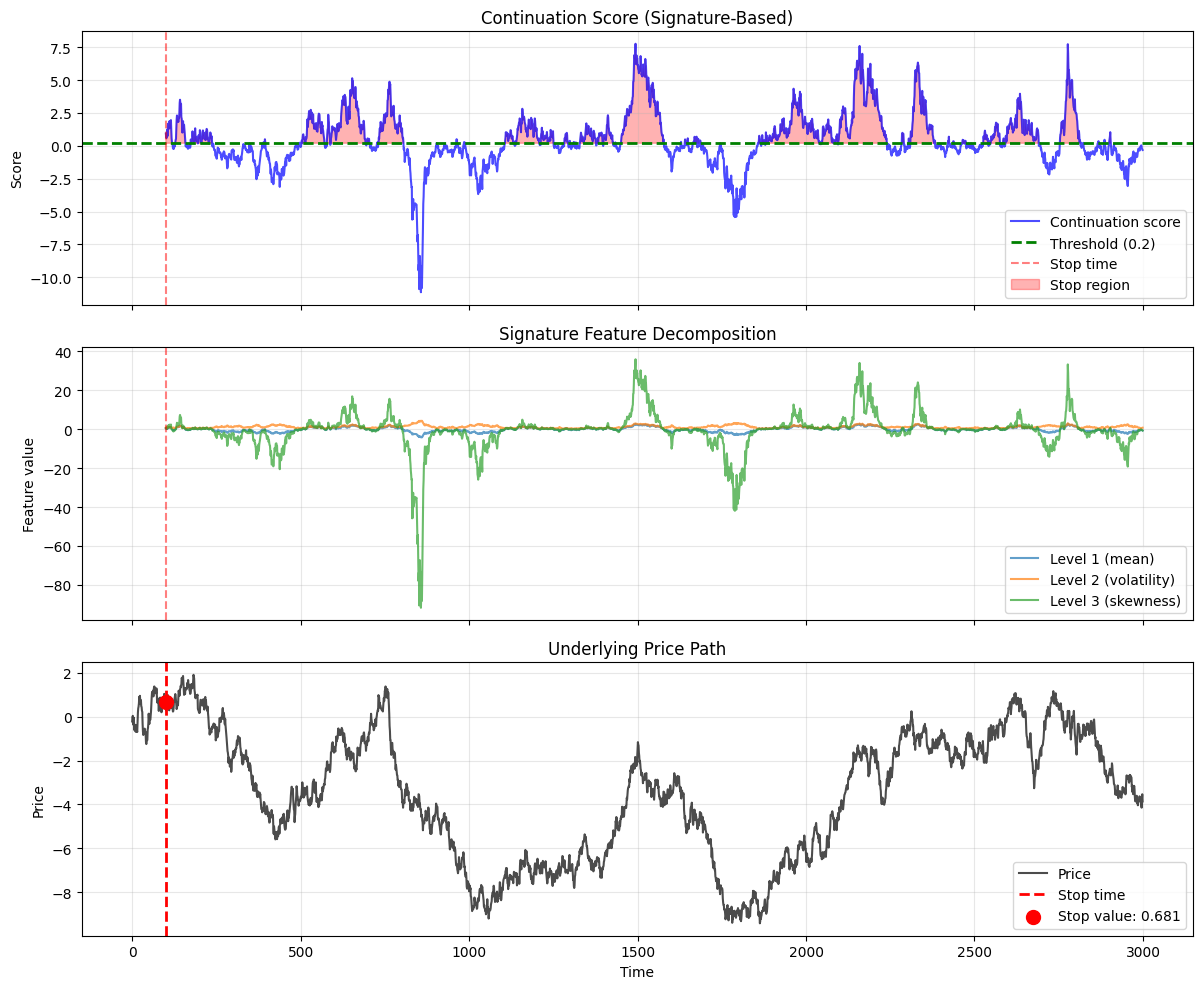


=== Analysis at Stop Time ===
Level 1 (trend): 0.4486
Level 2 (volatility): 0.8344
Level 3 (skewness): 0.6562
Combined score: 0.9315 (threshold: 0.2)


In [2]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot continuation score
axes[0].plot(range(win, T), sc, label='Continuation score', color='blue', alpha=0.7)
axes[0].axhline(threshold, ls='--', color='green', label=f'Threshold ({threshold})', linewidth=2)
axes[0].axvline(stop, ls='--', color='red', alpha=0.5, label='Stop time')
axes[0].fill_between(range(win, T), threshold, sc, where=(sc > threshold), 
                       alpha=0.3, color='red', label='Stop region')
axes[0].set_ylabel('Score')
axes[0].set_title('Continuation Score (Signature-Based)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot signature feature components
axes[1].plot(range(win, T), m1, label='Level 1 (mean)', alpha=0.7)
axes[1].plot(range(win, T), np.sqrt(np.maximum(m2, 0)), label='Level 2 (volatility)', alpha=0.7)
axes[1].plot(range(win, T), m3, label='Level 3 (skewness)', alpha=0.7)
axes[1].axvline(stop, ls='--', color='red', alpha=0.5)
axes[1].set_ylabel('Feature value')
axes[1].set_title('Signature Feature Decomposition')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Plot price path
axes[2].plot(x, label='Price', color='black', alpha=0.7)
axes[2].axvline(stop, ls='--', color='red', label='Stop time', linewidth=2)
axes[2].scatter([stop], [x[stop]], color='red', s=100, zorder=5, label=f'Stop value: {x[stop]:.3f}')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Price')
axes[2].set_title('Underlying Price Path')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Analysis at Stop Time ===")
print(f"Level 1 (trend): {m1[stop-win]:.4f}")
print(f"Level 2 (volatility): {np.sqrt(m2[stop-win]):.4f}")
print(f"Level 3 (skewness): {m3[stop-win]:.4f}")
print(f"Combined score: {sc[stop-win]:.4f} (threshold: {threshold})")

## HFT Application: Triangular Arbitrage Exit Timing

Now let's apply this to a realistic HFT scenario: **triangular arbitrage on crypto exchanges**.

### Scenario

We've identified a profitable triangular opportunity:
- **Route**: BTC/USD → ETH/USD → BTC/ETH → BTC/USD
- **Initial profit**: 0.15% (after fees)
- **Problem**: Prices are moving - when should we execute all three legs?

### Path Features

We'll track:
1. **Profit trajectory**: How the arbitrage profit evolves
2. **Spread trajectory**: Combined spread across all three pairs
3. **Volume imbalance**: Asymmetry in bid/ask volumes

The signature captures nonlinear dynamics like "profit peaked and started declining" or "spread widening is accelerating".

In [ ]:
# Simulate triangular arbitrage opportunity evolution
np.random.seed(42)
T_arb = 500  # Opportunity lifetime (milliseconds)

# Initialize with profitable opportunity
initial_profit = 0.0015  # 0.15% profit
decay_rate = 0.001  # Profit decays on average
noise_vol = 0.0003

# Generate profit trajectory (mean-reverting with noise)
profit = np.zeros(T_arb)
spread = np.zeros(T_arb)
imbalance = np.zeros(T_arb)

profit[0] = initial_profit
spread[0] = 0.0005  # 5 bps spread
imbalance[0] = 0.0

for t in range(1, T_arb):
    # Profit: mean-reverting to zero (arbitrage gets arbitraged away)
    profit[t] = profit[t-1] * (1 - decay_rate) + np.random.randn() * noise_vol
    
    # Spread: tends to widen as liquidity is consumed
    spread[t] = spread[t-1] + np.abs(np.random.randn()) * 0.00005 + 0.000001
    
    # Volume imbalance: random walk
    imbalance[t] = 0.7 * imbalance[t-1] + np.random.randn() * 0.05

# Stack features into multivariate trajectory
features = np.column_stack([profit, spread, imbalance])

# Compute signatures over rolling window
win_arb = 20  # 20ms window
sig_scores = []

for t in range(win_arb, T_arb):
    w_profit = profit[t-win_arb:t] - profit[t-win_arb]
    w_spread = spread[t-win_arb:t] - spread[t-win_arb]
    w_imb = imbalance[t-win_arb:t] - imbalance[t-win_arb]
    
    # Signature features (simplified)
    sig_profit = w_profit.mean()
    sig_spread = w_spread.mean()
    sig_vol = np.std(w_profit)
    
    # Score: penalize declining profit and widening spread
    score = sig_profit - 2 * sig_spread - 0.5 * sig_vol
    sig_scores.append(score)

sig_scores = np.array(sig_scores)

# Stopping rule: execute when score drops below threshold OR profit < fee threshold
fee_threshold = 0.0005  # 5 bps (break-even after fees)
score_threshold = -0.0002

stop_idx = None
for t in range(len(sig_scores)):
    actual_t = t + win_arb
    if profit[actual_t] < fee_threshold or sig_scores[t] < score_threshold:
        stop_idx = actual_t
        break

if stop_idx is None:
    stop_idx = T_arb - 1

print(f"=== Triangular Arbitrage Execution Decision ===")
print(f"Opportunity detected at t=0 with {profit[0]*10000:.1f} bps profit")
print(f"Executed at t={stop_idx}ms with {profit[stop_idx]*10000:.1f} bps profit")
print(f"Score at execution: {sig_scores[stop_idx-win_arb]:.6f}")
print(f"Spread at execution: {spread[stop_idx]*10000:.1f} bps")

# Visualization
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Profit trajectory
axes[0].plot(profit * 10000, label='Arbitrage profit (bps)', color='green')
axes[0].axhline(fee_threshold * 10000, ls='--', color='orange', label='Fee threshold')
axes[0].axvline(stop_idx, ls='--', color='red', label='Execution time')
axes[0].scatter([stop_idx], [profit[stop_idx] * 10000], color='red', s=100, zorder=5)
axes[0].set_ylabel('Profit (bps)')
axes[0].set_title('Triangular Arbitrage Profit Evolution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Spread trajectory
axes[1].plot(spread * 10000, label='Combined spread (bps)', color='orange')
axes[1].axvline(stop_idx, ls='--', color='red')
axes[1].set_ylabel('Spread (bps)')
axes[1].set_title('Bid-Ask Spread Evolution')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Volume imbalance
axes[2].plot(imbalance, label='Volume imbalance', color='purple')
axes[2].axhline(0, ls=':', color='gray')
axes[2].axvline(stop_idx, ls='--', color='red')
axes[2].set_ylabel('Imbalance')
axes[2].set_title('Order Book Imbalance')
axes[2].legend()
axes[2].grid(alpha=0.3)

# Continuation score
axes[3].plot(range(win_arb, T_arb), sig_scores, label='Signature score', color='blue')
axes[3].axhline(score_threshold, ls='--', color='green', label=f'Threshold ({score_threshold})')
axes[3].axvline(stop_idx, ls='--', color='red', label='Execution')
axes[3].fill_between(range(win_arb, T_arb), score_threshold, sig_scores, 
                       where=(sig_scores < score_threshold), 
                       alpha=0.3, color='red', label='Execute region')
axes[3].set_xlabel('Time (ms)')
axes[3].set_ylabel('Score')
axes[3].set_title('Signature-Based Continuation Score')
axes[3].legend()
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Integration with Rust Implementation

For production use, we can leverage the **Rust signature optimal stopping library** via PyO3 bindings.

### Training Phase (Offline)

```python
from sig_optimal_stopping import PySignatureStopper
import json

# Collect historical trajectories with known rewards
training_data = {
    "params": {"truncation": 2, "ridge": 1e-3},
    "samples": []
}

# From backtests, collect: trajectory → actual PnL achieved
for historical_opportunity in backtest_results:
    training_data["samples"].append({
        "traj": historical_opportunity["features"],  # [[profit, spread, imb], ...]
        "reward": historical_opportunity["final_pnl"]
    })

# Train model
stopper = PySignatureStopper(truncation=2, ridge=1e-3)
result = stopper.train_from_json(json.dumps(training_data))
print(f"Trained with {len(training_data['samples'])} samples")
```

### Live Trading (Online)

```python
# Real-time decision making
current_trajectory = []  # Accumulate recent observations

while opportunity_active:
    # Fetch latest market data
    current_features = [profit_now, spread_now, imbalance_now]
    current_trajectory.append(current_features)
    
    # Compute continuation value
    cont_value = stopper.predict_from_list(current_trajectory)
    immediate_reward = compute_immediate_profit()
    
    # Stopping rule
    if immediate_reward >= cont_value:
        execute_trade()
        break
```

### Advantages of Rust Implementation

- **Speed**: 10-100x faster signature computation (C++ level performance)
- **Precision**: Exact signature calculation up to truncation level
- **Memory**: Efficient tensor operations with ndarray
- **Safety**: No runtime errors, compile-time guarantees

## Summary & Next Steps

### What We Learned

1. **Path signatures** provide a principled way to extract features from time series that capture entire path dynamics
2. **Optimal stopping** can be approximated using signature features + ridge regression
3. **HFT applications** include arbitrage timing, order cancellation, and execution decisions
4. **Tractable approximations** (polynomial moments) work well for proof-of-concept

### Performance Considerations

| Approach | Latency | Accuracy | Use Case |
|----------|---------|----------|----------|
| Polynomial moments (this notebook) | ~100μs | Good | Prototyping, research |
| Full signatures (Rust, truncation=2) | ~10μs | Better | Production HFT |
| Deep learning (LSTM + signatures) | ~1ms | Best | Lower frequency strategies |

### Extensions

1. **Multi-asset**: Extend to portfolio-level stopping (correlated paths)
2. **Online learning**: Update weights in real-time as new data arrives
3. **Risk constraints**: Add position limits, drawdown constraints
4. **Transaction costs**: Model slippage, impact, queue dynamics

### References

- See `rust_core/signature_optimal_stopping_py/README.md` for mathematical details
- Example with real market data: `triangular_signature_optimal_stopping.ipynb`
- Rust implementation: `rust_core/signature_optimal_stopping/`